<a href="https://colab.research.google.com/github/KinuthiaWambugu/colabnotebooksAA/blob/AA/Workshop_4_2_Etudiant_EN_REV_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Performance and optimization of metaheuristics<br/> Workshop</center>

![logoEI_1_6.jpg](attachment:logoEI_1_6.jpg)

# 1. Introduction
We take the [knapsack](https://en.wikipedia.org/wiki/Knapsack_problem) problem for the last time, and we will try to find out if the algorithms we have designed are efficient.


Start by incorporating the code of the tabu search you designed last time.

In [51]:
from collections import deque
import random
from functools import lru_cache

def random_objets(poids_max, val_max):
 """
 This function generates objects of random weight and value
 (bounded by the values passed as parameters).

 Returns a tuple of 2 dictionaries (weight,value)
 """
 poids_objets = {i:random.randint(1, poids_max) for i in range(nb_objets)}
 valeur_objets = {i:random.randint(1, val_max) for i in range(nb_objets)}

 return poids_objets, valeur_objets

def random_solution():
 sac = tuple(random.choice([True, False]) for _ in range(nb_objets)) # COMPLETED

 while (poids_contenu(sac) > capacite):
     # list of `True` value indices in the bag
     objets_presents = [i for i, val in enumerate(sac) if val] # COMPLETED

     # random choice of an object to delete among those present in the bag
     if objets_presents:
        objet_supprime = random.choice(objets_presents)

        # deletion of the randomly selected object
        sac = sac[:objet_supprime] + (False,) + sac[objet_supprime + 1:] # COMPLETED

 return sac
random.seed(a=3)
@lru_cache(maxsize=None)
def poids_contenu(sac):
 """
 This function returns the sum of the weights of the objects in the bag
 """
 return sum([poids_objets[i] for i, val in enumerate(sac) if val])


@lru_cache(maxsize=None)
def valeur_contenu(sac):
 """
 This function returns the sum of the values of the objects in the bag
 """
 return sum([valeur_objets[i] for i, val in enumerate(sac) if val])

@lru_cache(maxsize=None)
def voisinage(sac):
 """
 This function is a generator of all valid neighbours of a solution
 """
 result = []
 for k in range(len(sac)):
   neighbor = sac[:k] + (not sac[k],) + sac[k+1:]
   if (poids_contenu(neighbor) <= capacite):
     result.append(neighbor)

 return result

def recherche_tabou(solution_initiale, taille_tabou, iter_max):
 """
 1. We start from an element of our search set that we state current element
 2. We consider the neighbourhood of the current element, we choose the best of them
 as a new current element, among those missing from the tabu list, and we add it
 to the tabu list
 3. We run a loop until the output condition is reached.
 """
 nb_iter = 0
 liste_tabou = deque(maxlen = taille_tabou)

 # variables solutions for finding the neighbour optimal not tabu
 solution_courante = solution_initiale
 meilleure = solution_initiale
 meilleure_globale = solution_initiale

 # variables values for finding neighbour optimal not tabu
 valeur_meilleure = valeur_contenu(solution_initiale)
 valeur_meilleure_globale = valeur_meilleure


 while (nb_iter < iter_max):
  valeur_meilleure = -1

 # we go through all the neighbours of the current solution
  for voisin in voisinage(solution_courante):
    valeur_voisin = valeur_contenu(voisin)

    if valeur_voisin > valeur_meilleure and voisin not in liste_tabou:
      meilleure = voisin
      valeur_meilleure = valeur_voisin

 # we update the best solution encountered since the beginning
  if valeur_meilleure > valeur_meilleure_globale:
    meilleure_globale = meilleure
    valeur_meilleure_globale = valeur_meilleure
    nb_iter = 0
  else:
    nb_iter += 1

 # we go to the best non-tabu neighbour found
  solution_courante = meilleure

 # we update the tabu list
  liste_tabou.append(solution_courante)

 return meilleure_globale

Let’s relaunch our method&nbsp;!

In [22]:
nb_objets = 100
capacite = 20
random.seed(a=3)
poids_objets, valeur_objets = random_objets(10, 10)
sac = (False,)*nb_objets

print("tabou de taille 5")
sol = recherche_tabou(sac, taille_tabou=5, iter_max=30)
print("final value = " + str(valeur_contenu(sol)) + ", Capacity="+str(poids_contenu(sol)) + "/" + str(capacite))
print([i for i, val in enumerate(sol) if val]) # composition of the solution

tabou de taille 5
final value = 62, Capacity=20/20
[24, 27, 30, 41, 44, 45, 62]


# 2. Behaviour of the algorithm

We get a feasible solution using our algorithm, but we don’t really know how the algorithm got it. Under these conditions, it’s hard to imagine what could be done to improve the solution obtained. Let’s try to see how the algorithm comes to this result.

## 2.1 Trajectory study

Let’s start by studying the trajectory that our algorithm follows. It’s quite simple - just select all current solutions and the history of the best solutions found at each iteration, and display all that with [matplotlib](https://matplotlib.org/index.html). Let’s go!



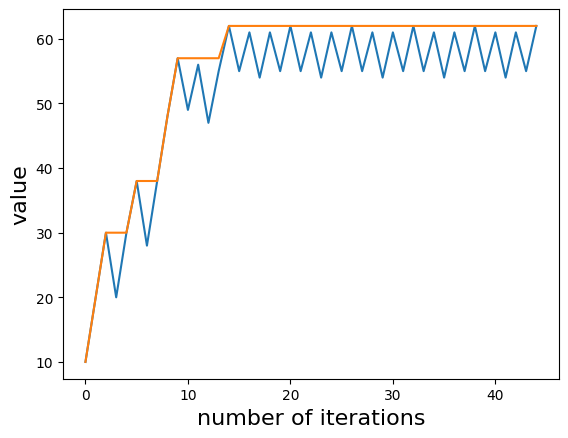

In [25]:
import matplotlib.pyplot as plt
from collections import deque

def recherche_tabou_traject(solution_initiale, taille_tabou, iter_max):
    """
    1. We start from an element of our search set that we state current element
    2. We consider the neighbourhood of the current element, we choose the best of them
       as a new current element, among those missing from the tabu list, and we add it
       to the tabu list
    3. We run a loop until the output condition is reached.
    """
    nb_iter = 0
    liste_tabou = deque((), maxlen=taille_tabou)

    # Variables for finding the optimal non-tabu neighbor
    solution_courante = solution_initiale
    meilleure = solution_initiale
    meilleure_globale = solution_initiale

    # Values for finding optimal non-tabu neighbor
    valeur_meilleure = valeur_contenu(solution_initiale)
    valeur_meilleure_globale = valeur_meilleure

    # Lists of current and best solutions found, to display the trajectory
    meilleures_courantes = deque()
    courantes = deque()

    while nb_iter < iter_max:
        nb_iter += 1
        valeur_meilleure = 0

        # We go through all the neighbors of the current solution
        for voisin in voisinage(solution_courante):
            valeur_voisin = valeur_contenu(voisin)

            # Check if the neighbor is not in the tabu list and is better
            if valeur_voisin > valeur_meilleure and voisin not in liste_tabou:
                meilleure = voisin
                valeur_meilleure = valeur_voisin

        # Update the best solution found since the beginning
        if valeur_meilleure > valeur_meilleure_globale:
            meilleure_globale = meilleure
            valeur_meilleure_globale = valeur_meilleure
            nb_iter = 0

        meilleures_courantes.append(valeur_meilleure_globale)
        courantes.append(valeur_meilleure)

        # Move to the best non-tabu neighbor found
        solution_courante = meilleure

        # Update the tabu list
        liste_tabou.append(solution_courante)

    return meilleure_globale, courantes, meilleures_courantes

sac = (False,) * nb_objets

iter_max = 30
taille_tabou = 5
sol, courants, meilleurs_courants = recherche_tabou_traject(sac, taille_tabou, iter_max)

plt.xlabel("number of iterations", fontsize=16)
plt.ylabel("value", fontsize=16)
res = plt.plot(range(len(courants)), courants)
res = plt.plot(range(len(courants)), meilleurs_courants)

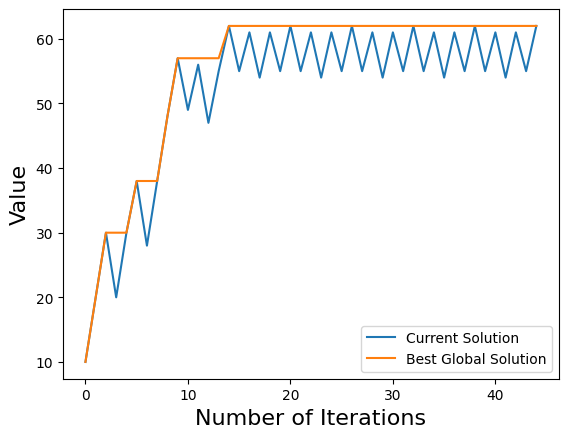

In [26]:
import matplotlib.pyplot as plt
from collections import deque
import random

def recherche_tabou_traject(solution_initiale, taille_tabou, iter_max):
    """
    Tabu Search algorithm implementation with trajectory tracking.
    """
    nb_iter = 0
    liste_tabou = deque((), maxlen=taille_tabou)

    # Initialize variables
    solution_courante = solution_initiale
    meilleure = solution_initiale
    meilleure_globale = solution_initiale

    valeur_meilleure = valeur_contenu(solution_initiale)
    valeur_meilleure_globale = valeur_meilleure

    # Lists to store the current and best solutions found
    courantes = deque()
    meilleures_courantes = deque()

    while nb_iter < iter_max:
        nb_iter += 1
        valeur_meilleure = -1  # Initialize the best neighbor value below any possible value

        # Explore neighbors
        for voisin in voisinage(solution_courante):
            valeur_voisin = valeur_contenu(voisin)
            if valeur_voisin > valeur_meilleure and voisin not in liste_tabou:
                meilleure = voisin   # Store the best neighbor
                valeur_meilleure = valeur_voisin

        # Check if the best found neighbor improves the global best solution
        if valeur_meilleure > valeur_meilleure_globale:
            meilleure_globale = meilleure
            valeur_meilleure_globale = valeur_meilleure
            nb_iter = 0  # Reset iteration count if improvement is found

        # Append current and best values to the lists
        courantes.append(valeur_meilleure)
        meilleures_courantes.append(valeur_meilleure_globale)

        # Move to the best non-tabu neighbor found
        solution_courante = meilleure

        # Update the tabu list
        liste_tabou.append(solution_courante)

    return meilleure_globale, courantes, meilleures_courantes

# Example setup and plotting
# Assume nb_objets, capacite, voisinage, and the other helper functions are defined
sac = (False,) * nb_objets
iter_max = 30
taille_tabou = 5

# Run the tabu search
sol, courants, meilleurs_courants = recherche_tabou_traject(sac, taille_tabou, iter_max)

# Plot the results
plt.xlabel("Number of Iterations", fontsize=16)
plt.ylabel("Value", fontsize=16)
plt.plot(range(len(courants)), courants, label="Current Solution")
plt.plot(range(len(meilleurs_courants)), meilleurs_courants, label="Best Global Solution")
plt.legend()
plt.show()


We observe an interesting phenomenon after a while. What is it called&nbsp;? How can we interpret it, and what can we do about it&nbsp;?

<em>Solution is stuck at the local optimum, the basin of attraction.</em>

Let’s test this solution (with a value of 200, for example)&nbsp;:

Text(0, 0.5, 'value')

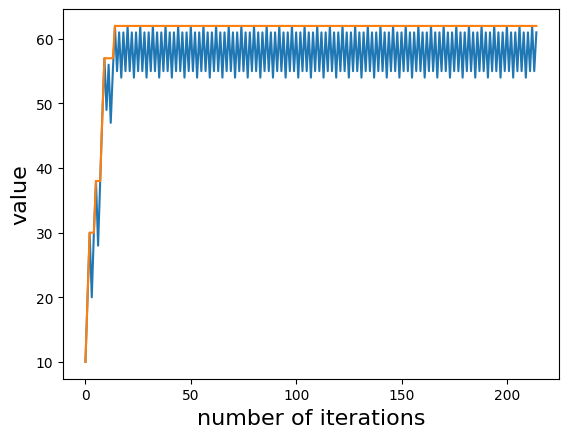

In [28]:
sac=(False,)*nb_objets
iter_max = 200
taille_tabou = 5
sol, courants, meilleurs_courants=recherche_tabou_traject(sac, taille_tabou, iter_max)

plt.plot(range(len(courants)), courants)
plt.plot(range(len(courants)), meilleurs_courants)
plt.xlabel("number of iterations", fontsize=16)
plt.ylabel("value", fontsize=16)

How do you interpret this curve&nbsp;?

<em>TO BE COMPLETED</em>

So let’s try to increase the value further.

Text(0, 0.5, 'value')

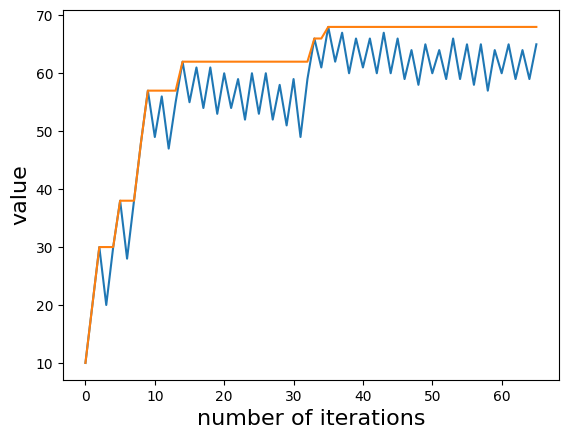

In [30]:
sac=(False,)*nb_objets
iter_max = 30
taille_tabou = 200
#TO BE COMPLETED
sol, courants, meilleurs_courants=recherche_tabou_traject(sac, taille_tabou, iter_max)

plt.plot(range(len(courants)), courants)
plt.plot(range(len(courants)), meilleurs_courants)
plt.xlabel("number of iterations", fontsize=16)
plt.ylabel("value", fontsize=16)

What is the result? How can this be fixed?

<em>TO BE COMPLETED</em>

Let’s try with the same value as for the list size.

Text(0, 0.5, 'value')

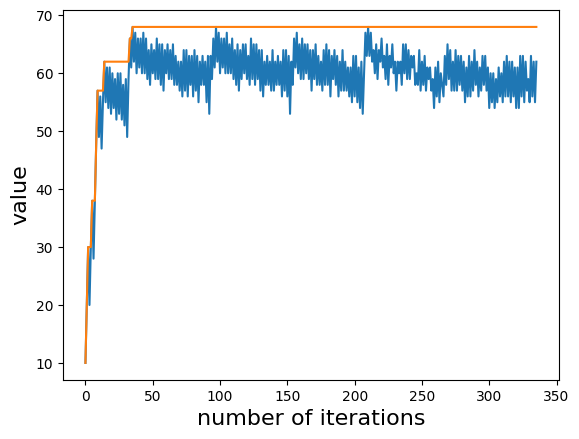

In [31]:
sac=(False,)*nb_objets
iter_max = 300
taille_tabou = 300
#TO BE COMPLETED
sol, courants, meilleurs_courants=recherche_tabou_traject(sac, taille_tabou, iter_max)

plt.plot(range(len(courants)), courants)
plt.plot(range(len(courants)), meilleurs_courants)
plt.xlabel("number of iterations", fontsize=16)
plt.ylabel("value", fontsize=16)

What do we observe?

<em>TO BE COMPLETED</em>

## 2.2 Quality of the solution

But ultimately, we don't know if this solution that our algorithm generates is really good. We know that we have improved it since Hill-Climbing, and that we can do better, since the multi-start does it. This may be a difficult question to answer. Why&nbsp;?

<font color = "yellow">
<em>We don't know how close we are to the optimal solution.</em>

But we could still try to find a point of comparison, less precise, but which still brings us some information. And the solution is in fact very simple, it is found in the Workshop on the linear programming. Remember, we had already worked on the knapsack problem. Did we manage to solve it&nbsp;? Why&nbsp;?

<font color = "yellow">
<em>No we didn't.</em>

And what did the problem-solving method that we had tried to put in place produce&nbsp;?

<font color = "yellow">
<em>It provides us with an unfeasible solution however, it gives us a maximum upper bound for where our optimal solution may lie.</em>


Here is our indicator&nbsp;! Thanks to this, we will be able to set up a [design of experiments](https://en.wikipedia.org/wiki/Design_of_experiments) (there’s no need to directly apply the mathematical principles mentioned in this link, they are just there to give you an idea of the general principle, and are tools rarely used as such in the field of algorithm evaluation).


Once we have obtained an upper bound of the optimal for our instance, if the solution we have generated is far from the bound, what conclusion can we draw&nbsp;?

<font color = "yellow">
<em> That the solution for our algorithm is underperforming. The gap suggests that we might be missing valuable combinations of items, either because of insufficient exploration or premature convergence to suboptimal local optima. This would prompt us to explore more advanced or diverse search techniques.</em>

What if our solution is close to the bound&nbsp;?

<font color = "yellow">
<em> If our solution is close to the LP upper bound, it implies that our metaheuristic is effective and captures much of the optimal solution's value. While it’s not necessarily the true optimal integer solution, being near the upper bound is a positive indicator that our method approximates optimality well, as it has reached nearly the maximum possible value within the problem constraints.</em>

All we have to do now is to take the code from linear programming. Let's test this&nbsp;:



In [33]:
# we give you the ready-made solution!
!pip install pulp
from pulp import *

def borne_superieure():
 objets = range(nb_objets)

 # variables
 x = LpVariable.dicts('objet', objets, 0, 1)

 # problem
 prob = LpProblem("knapsack", LpMaximize)

 # objective function
 cost = lpSum([valeur_objets[i]*x[i] for i in objets])
 prob += cost

 # constraint
 prob += lpSum([poids_objets[i]*x[i] for i in objets]) <= capacite

 prob.solve()
 return value(prob.objective) if (LpStatus[prob.status] == "Optimal") else None

borne = borne_superieure()
if borne is not None:
 print("upper bound: ", borne)
print("solution value:", str(valeur_contenu(sol)))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 53.3 MB/s eta 0:00:00
upper bound:  91.33333329999999
solution value: 68


It's not bad, but we can surely do better&nbsp;! Typically by doing a multistart. By the way, let's see what it gives&nbsp;:

In [37]:
import random
random.seed(a=5)

sol_max = None
val_max = 0

# multi-start of 500 iterations
for _ in range (500):
 sac = random_solution()
 sol_courante = recherche_tabou(sac, taille_tabou, iter_max)
 val_courante = valeur_contenu(sol_courante)
 if (val_courante > val_max):
  val_max = val_courante
  sol_max = sol_courante

print("final value = " + str(valeur_contenu(sol_max)))

final value = 91


How do you interpret these results&nbsp;?

<font color = "yellow">
<em>Basically, multistart is better/ more efficient than single start.</em>

Remember, in the previous workshop, two runs of the multistart gave the same solution value. Here it is, the explanation&nbsp;!

But we decided to stick to simple tabu algorithms. Let's come back to it, and try to get a better idea of its performance.

# 3. Design of experiments and optimization of the algorithm

We managed to build a solution to 2/3 of the bound (or even more if we use the multi-start) of our random instance. But can we generalize this result&nbsp;?

<font color = "yellow">
<em>It is not representative since it is only on one instance (random instance).</em>

## 3.1 Statistical quality of the solutions

To get a more accurate idea of the algorithm performance, it would be necessary to test a large number of instances. But this approach poses a big problem with respect to the optimization that we implemented last time to speed up the calculations. What is this problem&nbsp;?

<font color = "yellow">
<em>Since we used caching (memoization), it is necessary to calculate each instance and their solution and distance between the lower bound. Memoization of this works if the instance doesn't change.</em>

How can we remedy this without giving up this optimization, which may be useful if we have to do a large number of tests&nbsp;?

<font color = "yellow">
<em>Clear cache of the function. To define all the functions as nested functions. </em>

Let's fix that right now&nbsp;!

In [49]:
def random_objets(poids_max, val_max):
 """
 This function generates objects of random weight and value
 (limited by the values passed in parameter).

 Returns a tuple of 2 dictionaries (weight,value)
 """

 #TO BE COMPLETED
 poids_objets.cache_clear()
 valeur_objets.cache_clear()
 voisinage.cache_clear()

 poids_objets = {i: random.randint(1, poids_max) for i in range(nb_objets)}
 valeur_objets = {i: random.randint(1, val_max) for i in range(nb_objets)}

 return poids_objets, valeur_objets

Problem solved&nbsp;! We can tackle the implementation of our statistical test. Let's go back to the size of tabu and the number of iterations which gave good results earlier. Moreover, to try to increase the representativeness of our results, we will provide the search with a random initial solution for each test.

And since we are starting to have calculations that take time again, we will reuse the progress bar of the first Workshop. For this time, you are reminded of the code.

In [52]:
from ipywidgets import IntProgress
from IPython.display import display

random.seed(a=3)
bounds = deque(())

iter_max = 200 #SOLUTION
tabu_size = 100 #SOLUTION

# test parameters
nb_tests = 200

# we display the progress bar
bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
display(bar)

for _ in range(nb_tests):
 # random generation of the instance and calculation of
 # its upper bound.

 poids_objets, valeur_objets = random_objets(10, 10) #SOLUTION
 bound = upper_bound() #SOLUTION
 #SOLUTION
 sack = random_solution() #SOLUTION
 sol = tabu_search(sack, tabu_size, iter_max) #SOLUTION
 val = sack_value(sol) #SOLUTION
 distance = bound-val #SOLUTION
 bounds.append(distance)
 bar.value += 1

# we hide the progress bar
bar.close()

print(sum(bounds) / len(bounds))


IntProgress(value=0, layout=Layout(width='100%'), max=200)

NameError: name 'upper_bound' is not defined

In [53]:
from ipywidgets import IntProgress
from IPython.display import display

random.seed(a=3)
bornes = deque(())

#TO BE COMPLETED
iter_max = 200
taille_tabou = 100

# test parameters
nb_tests = 200

# we display the progress bar
bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
display(bar)

for _ in range(nb_tests):
 #TO BE COMPLETED
 poids_objets, valeur_objets = random_objets(10, 10)
 bornes = borne()

 sac = random_solution()
 sol = recherche_tabou(sac, taille_tabou, iter_max)
 val = valeur_contenu(sol)
 distance = bornes - val
 bornes.append(distance)
 bar.value += 1

# we hide the progress bar
bar.close()

print(sum(bornes) / len(bornes))

IntProgress(value=0, layout=Layout(width='100%'), max=200)

TypeError: 'float' object is not callable

Let's take a closer look at the values we get. That's good, we have the list of all distances. How could these values be examined in more detail&nbsp;?

font
<em>We can plot a histogram</em>

Let's try this&nbsp;!

In [ ]:
#TO BE COMPLETED

The bulk of the values are between 10 and 30. But that doesn't tell us much. What information are we missing&nbsp;?

<em>Can show the percentafe</em>

No luck, you have to redo the calculations&nbsp;!



In [ ]:
random.seed(a=3)
bornes = deque(())

# we display the progress bar
bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
display(bar)

for _ in range(nb_tests):
 #TO BE COMPLETED

# we hide the progress bar
bar.close()

#TO BE COMPLETED

The representation is a bit crude, 'matplotlib' used too large a grouping interval of values. Which parameter will we have to modify to make a finer display&nbsp;?

<em>The use of bins in matplotlib</em>

Luckily, this time, no need to recalculate, we already have the values in the variable `limits`. Just redo a display of these values&nbsp;:

In [ ]:
#TO BE COMPLETED

There, now it’s more readable&nbsp;! It is clear that the vast majority of our solutions are above 70 % of the limit. What is the most representative value of the algorithm's behaviour&nbsp;? What descriptive statistics could answer this question&nbsp;?

<em>You can look at the mean, average value.</em>

Let's see what it gives. Depending on performance levels, we can use the functions from Python’s standard [statistics](https://docs.python.org/fr/3.7/library/statistics.html) module, or [NumPy’s statistics functions](https://numpy.org/doc/stable/reference/routines.statistics.html).



In [ ]:
import statistics #mean / fmean + std. np(bounds)
import numpy as np # sum(bounds)/ len(bounds)

#TO BE COMPLETED

How do you interpret these results?&nbsp;

<font color = "yellow">
<em>They are quite satisfactory. The mean and median are almost equal by the fact the distribution is quite symmetrical. We will therefore use mean/ sd couple.</em>

## 3.2 Optimization of algorithm parameters

Although the behaviour seems quite acceptable, there are still instances for which things are not going so well. Couldn’t we find a parameterization of the algorithm that is better for these instances&nbsp;?

To answer this question, we will look at the impact of the size of the tabu list on quality. The goal will be to display, with Matplotlib, the mean in the form of a curve, and the standard deviation by means of a ‘strip' enclosing the curve&nbsp;:
![curve.png](attachment:curve.png)



In [ ]:
random.seed(a=3)

# test parameters
tabou_min = 1
tabou_max = 40
nb_objets = 200

nb_test = 100
iter_max = 20

# we display the progress bar
nb_steps_bar = #TO BE COMPLETED
bar = IntProgress(min=0, max=nb_steps_bar, layout={"width" : "100%"})
display(bar)

# to store results
moyennes = []
deviations = []

random.seed(a=3)

# this time we loop on the size of the tabu list
#TO BE COMPLETED

# we hide the progress bar
bar.close()

# display of the average curve
plt.plot(range(tabou_min, tabou_max), moyennes)

# display of the standard deviation strip
plt.fill_between(range(tabou_min, tabou_max),
 np.subtract(moyennes, deviations), # high bound
 np.add(moyennes, deviations), # lower bound
 alpha=.1) # transparency
plt.xlabel("tabu list size")
plt.ylabel("distance to bound")
plt.title("Impact of the tabu list size on the quality of the solutions")
plt.show()

What do you observe&nbsp;?

<em>TO BE COMPLETED</em>

This opens up prospects for continuing the tests, and drawing conclusions on the most efficient parameters of the algorithm. How could we proceed&nbsp;?

<em>TO BE COMPLETED</em>

If we want to check this automatically, how could we proceed&nbsp;?

<em>TO BE COMPLETED</em>

In any case, everything suggests that our parameterization of the algorithm was not optimal. We lost in computation time compared to the quality of the generated solution.

## 3.3 Impact of instance parameters

But finally, we want to improve the performances on these difficult instances, while we don't even know what makes them complicated to solve. So, the question we can ask ourselves is&nbsp;: what makes a instance difficult&nbsp;?

To begin with, we will play with the number of objects, which is the simplest thing to implement.

In [ ]:
random.seed(a=3)

# test parameters
objets_min = 20
objets_max = 320
objets_steps = 20
nb_test = 200

taille_tabou = 5
iter_max = taille_tabou*2

nb_steps_bar = #TO BE COMPLETED

# we display the progress bar
bar = IntProgress(min=0, max=nb_steps_bar, layout={"width" : "100%"})
display(bar)

# to store results
moyennes = []
deviations = []

# we make the number of objects change in the random generation of instances
#TO BE COMPLETED

# we hide the progress bar
bar.close()

# display of the average curve
plt.plot(range(objets_min, objets_max, objets_steps), moyennes)

# display of the standard deviation strip
plt.fill_between(range(objets_min, objets_max, objets_steps),
 np.subtract(moyennes, deviations), # high bound
 np.add(moyennes, deviations), # lower bound
 alpha=.1) # transparency
plt.ylim(top=100)
plt.xlabel("number of available objects")
plt.ylabel("distance to bound")
plt.title("Impact of the number of objects on the quality of the solutions")
plt.show()

What do you think of these results&nbsp;? How do you interpret them&nbsp;?

<font color = "yellow">
<em>With an increase in tabu list size, </em>

## 3.4 To go even further

There are still many things that we could study to understand and above all improve how our algorithm works (not to mention the calculations you should perhaps redo with a greater number of tests per configuration). We only looked at the parameters alone, not the way in which they can be combined (or very little). And then we didn't look at the computation time at all. As when studying the theoretical complexity of algorithms, measuring the occupation time CPU will not necessarily be relevant. Which metric makes sense to you&nbsp;?

<em>TO BE COMPLETED</em>

In any case, it allowed us to improve the quality of the solution by refining the parameters of the tabu search to reinforce the diversification phase (which here seemed to cause us problem). If we encountered more difficult instances, which our algorithm could not solve efficiently, regardless of the parameterization, what could we do&nbsp;?

<em>TO BE COMPLETED</em>

And then, once all this work is done (and not before), we could also look at the multi-start. What do you think is relevant&nbsp;?

<em>TO BE COMPLETED</em>

# 4 Conclusion

This Workshop is now concluded, and we have a much more precise idea of how our metaheuristic behaves.



And if we pay a little attention, this experimental study that we performed is organized as a [design of experiments](https://en.wikipedia.org/wiki/Design_of_experiments) (for example, considering simple research before we can look at the multi-start, or defining a quality indicator in the first place). You will have to think about a similar plan for your project, so as not to waste time (especially since the calculations are rather long). On the other hand, do not push the approach to the point of applying the mathematical principles mentioned in the previous link, since these are tools rarely used as such in the field of algorithm evaluation).


You now have all the weapons to not only design and implement a metaheuristic, but also analyse its behaviour and optimize its parameters to get the best out of it.